<a href="https://colab.research.google.com/github/sushirito/Methylmercury/blob/main/TST_Boltzmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This code was inspired by: https://github.com/lbm-principles-practice/code/blob/master/chapter9/shanchen.cpp



Running time step 0
Min density: 0.0
Max density: 1.4997327367995288
Mean density: 1.4056332950618635


Saved: /content/lbm_output/density_plot_3d_00000.html


Saved: /content/lbm_output/velocity_magnitude_3d_00000.html


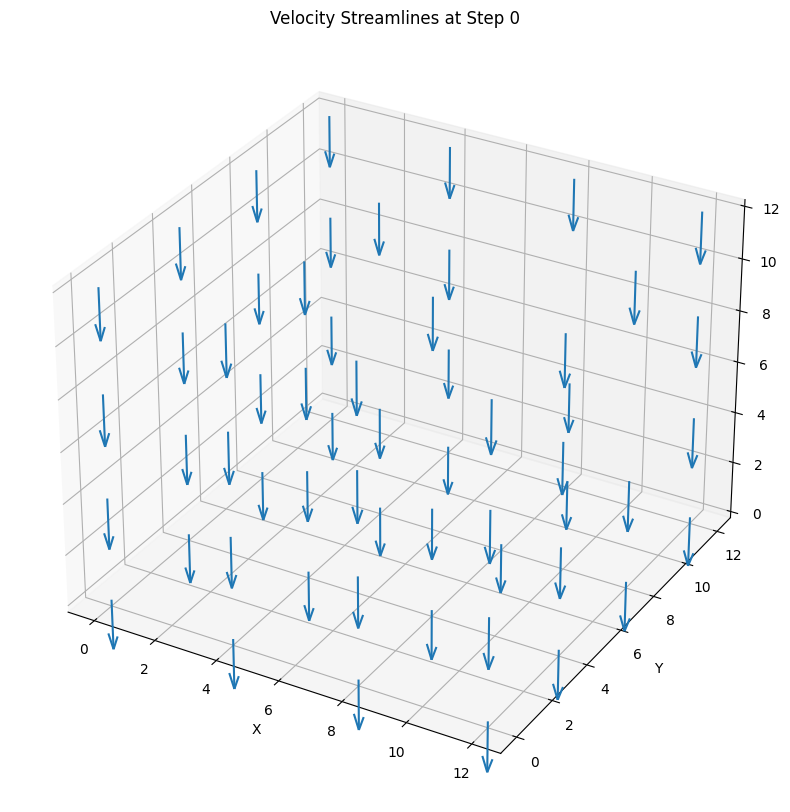

Saved: /content/lbm_output/velocity_streamlines_3d_00000.png
Running time step 100
Min density: 0.12327172691249912
Max density: 0.8479641643891195
Mean density: 0.81584362519658


Saved: /content/lbm_output/density_plot_3d_00100.html


Saved: /content/lbm_output/velocity_magnitude_3d_00100.html


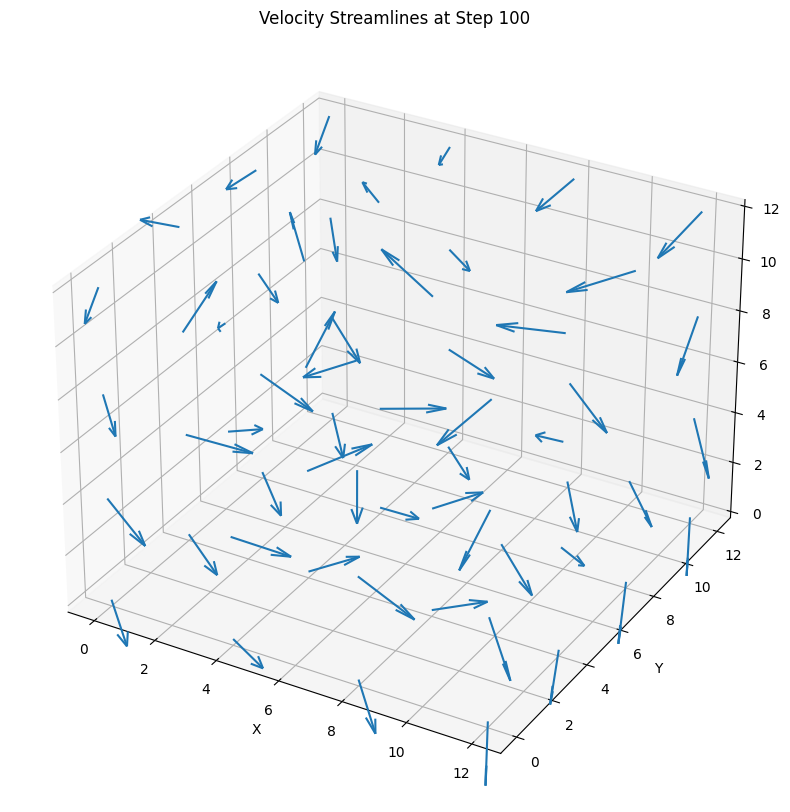

Saved: /content/lbm_output/velocity_streamlines_3d_00100.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go


# Lattice parameters
nx, ny, nz = 16, 16, 16
nsteps = 500
noutput = 100
nfluids = 1
tau = 1

# Shan-Chen parameters for a single fluid
gA = -0.16
rho0 = 1.0
rhol = 2.1
rhog = 0.15

# Solid-fluid interaction parameters
W = 0.15

# Gravitational force
g_gravity = 9.81e-5

# Fixed parameters for D3Q19
npop = 19
cx = np.array([0, 1,-1, 0, 0, 0, 0, 1,-1, 1,-1, 1,-1, 1,-1, 0, 0, 0, 0])
cy = np.array([0, 0, 0, 1,-1, 0, 0, 1, 1,-1,-1, 0, 0, 0, 0, 1,-1, 1,-1])
cz = np.array([0, 0, 0, 0, 0, 1,-1, 0, 0, 0, 0, 1, 1,-1,-1, 1, 1,-1,-1])
weight = np.array([1/3, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36])

# Weights for solid-fluid interactions
t_w = np.array([0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])



# Arrays
rho = np.zeros(nx * ny * nz)
press = np.zeros(nx * ny * nz)
ux = np.zeros(nx * ny * nz)
uy = np.zeros(nx * ny * nz)
uz = np.zeros(nx * ny * nz)
Fx = np.zeros(nx * ny * nz)
Fy = np.zeros(nx * ny * nz)
Fz = np.zeros(nx * ny * nz)
feq = np.zeros(npop)
forcing = np.zeros(npop)
f1 = np.zeros((nx * ny * nz, npop))
f2 = np.zeros((nx * ny * nz, npop))

def create_elementary_pattern(size=16):
    pattern = np.zeros((size, size, size), dtype=int)
    center = size // 2
    radius = size // 4
    for z in range(size):
        for y in range(size):
            for x in range(size):
                if (x - center)**2 + (y - center)**2 + (z - center)**2 <= radius**2:
                    pattern[z, y, x] = 1
    return pattern

def create_porous_medium(n_patterns=1):
    elementary_size = 16
    pattern = create_elementary_pattern(elementary_size)
    porous_medium = np.tile(pattern, (n_patterns, n_patterns, n_patterns))
    return porous_medium[:nx, :ny, :nz]  # Ensure it matches nx, ny, nz

solid = create_porous_medium()

def compute_density(pop):
    rho[:] = np.sum(pop, axis=1)

def psi(dens):
    return rho0 * (1.0 - np.exp(-dens / rho0))

def compute_sc_forces():
    for z in range(nz):
        for y in range(ny):
            for x in range(nx):
                k = z * nx * ny + y * nx + x
                Fx[k] = Fy[k] = Fz[k] = 0.0
                psiloc = psi(rho[k])
                for i in range(1, npop):
                    x2 = (x + cx[i] + nx) % nx
                    y2 = (y + cy[i] + ny) % ny
                    z2 = (z + cz[i] + nz) % nz
                    k2 = z2 * nx * ny + y2 * nx + x2
                    psinb = psi(rho[k2])
                    Fx[k] -= gA * weight[i] * cx[i] * psiloc * psinb
                    Fy[k] -= gA * weight[i] * cy[i] * psiloc * psinb
                    Fz[k] -= gA * weight[i] * cz[i] * psiloc * psinb
                    if solid[z2, y2, x2] == 1:
                        Fx[k] -= W * weight[i] * cx[i] * psiloc
                        Fy[k] -= W * weight[i] * cy[i] * psiloc
                        Fz[k] -= W * weight[i] * cz[i] * psiloc
                Fz[k] -= rho[k] * g_gravity
    return Fx, Fy, Fz

def compute_velocity(pop):
    for k in range(nx * ny * nz):
        dens = rho[k]
        if dens > 1e-10 and solid.flatten()[k] == 0:
            ux[k] = (np.sum(cx * pop[k]) + 0.5 * Fx[k]) / dens
            uy[k] = (np.sum(cy * pop[k]) + 0.5 * Fy[k]) / dens
            uz[k] = (np.sum(cz * pop[k]) + 0.5 * Fz[k]) / dens
        else:
            ux[k] = uy[k] = uz[k] = 0

def equilibrium(k):
    dens = rho[k]
    vx = ux[k]
    vy = uy[k]
    vz = uz[k]
    usq = vx*vx + vy*vy + vz*vz
    for i in range(npop):
        cu = cx[i]*vx + cy[i]*vy + cz[i]*vz
        feq[i] = weight[i] * dens * (1 + 3*cu + 4.5*cu*cu - 1.5*usq)

def initialisation():
    global f1, f2, rho
    rho = np.zeros(nx * ny * nz)
    rho_i = np.random.uniform(0.5, 1.9)
    for k in range(nx * ny * nz):
        if solid.flatten()[k] == 0:
            rho[k] = max(rho_i, 0.1)  # Ensure minimum density
        else:
            rho[k] = 0

    for k in range(nx * ny * nz):
        ux[k] = uy[k] = uz[k] = 0.0
        equilibrium(k)
        f1[k] = feq
        f2[k] = feq

def bounce_back_boundaries(f):
    for i in range(1, npop):
        f[solid.flatten() == 1, i] = f[solid.flatten() == 1, npop - i]
    return f

def push():
    global f1, f2
    omega = 1.0 / tau
    for z in range(nz):
        for y in range(ny):
            for x in range(nx):
                k = z * nx * ny + y * nx + x
                equilibrium(k)
                for i in range(npop):
                    forcing = weight[i] * (1 - 0.5*omega) * (
                        3 * ((cx[i] - ux[k])*Fx[k] + (cy[i] - uy[k])*Fy[k] + (cz[i] - uz[k])*Fz[k]) +
                        9 * (cx[i]*ux[k] + cy[i]*uy[k] + cz[i]*uz[k]) * (cx[i]*Fx[k] + cy[i]*Fy[k] + cz[i]*Fz[k])
                    )
                    x2 = (x + cx[i] + nx) % nx
                    y2 = (y + cy[i] + ny) % ny
                    z2 = (z + cz[i] + nz) % nz
                    k2 = z2 * nx * ny + y2 * nx + x2
                    f2[k2, i] = f1[k, i] * (1 - omega) + feq[i] * omega + forcing
    f2 = bounce_back_boundaries(f2)
    f1, f2 = f2, f1

def calculate_saturation():
    rho_threshold = (np.max(rho) + np.min(rho)) / 2
    liquid_nodes = np.sum((rho > rho_threshold) & (solid.flatten() == 0))
    total_fluid_nodes = np.sum(solid.flatten() == 0)
    saturation = liquid_nodes / total_fluid_nodes
    return saturation

output_dir = '/content/lbm_output'
os.makedirs(output_dir, exist_ok=True)

def save_html(fig, filename):
    filepath = os.path.join(output_dir, filename)
    fig.write_html(filepath)
    print(f"Saved: {filepath}")

def save_png(fig, filename):
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath)
    plt.close(fig)
    print(f"Saved: {filepath}")

def density_plot_3d(rho, step):
    # Generate meshgrid for 3D plotting
    x, y, z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz))
    scalar_field = rho.reshape((nz, ny, nx)).flatten()

    print(f"Min density: {np.min(scalar_field)}")
    print(f"Max density: {np.max(scalar_field)}")
    print(f"Mean density: {np.mean(scalar_field)}")

    # Create a 3D scatter plot using Plotly
    fig = go.Figure(data=go.Scatter3d(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        mode='markers',
        marker=dict(
            size=3,
            color=scalar_field,
            colorscale='Viridis',
            opacity=0.5,
            colorbar=dict(title='Density')
        )
    ))

    # Update plot layout
    fig.update_layout(
        title=f'Density Distribution at Step {step}',
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        )
    )

    fig.show()

    save_html(fig, f'density_plot_3d_{step:05d}.html')

def velocity_magnitude_plot_3d(ux, uy, uz, step):
    # Generate meshgrid for 3D plotting
    x, y, z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz))
    velocity_magnitude = np.sqrt(ux**2 + uy**2 + uz**2).reshape((nz, ny, nx)).flatten()

    # Create a 3D scatter plot for velocity magnitude
    fig = go.Figure(data=go.Scatter3d(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        mode='markers',
        marker=dict(
            size=3,
            color=velocity_magnitude,
            colorscale='Plasma',
            opacity=0.5,
            colorbar=dict(title='Velocity Magnitude')
        )
    ))

    # Update plot layout
    fig.update_layout(
        title=f'Velocity Magnitude at Step {step}',
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        )
    )

    fig.show()

    save_html(fig, f'velocity_magnitude_3d_{step:05d}.html')

'''
def velocity_streamplot_3d(ux, uy, uz, step):
    # Generate meshgrid and streamline data
    x, y, z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz))

    # Adjust grid skipping for better visualization
    skip = (slice(None, None, 2), slice(None, None, 2), slice(None, None, 2))

    # Downsampled data for plotting
    x_skip = x[skip].flatten()
    y_skip = y[skip].flatten()
    z_skip = z[skip].flatten()
    ux_skip = ux.reshape((nz, ny, nx))[skip].flatten()
    uy_skip = uy.reshape((nz, ny, nx))[skip].flatten()
    uz_skip = uz.reshape((nz, ny, nx))[skip].flatten()

    # Normalize vectors for visualization
    vector_length = np.sqrt(ux_skip**2 + uy_skip**2 + uz_skip**2)
    vector_length[vector_length == 0] = 1  # Avoid division by zero

    # Create a 3D cone plot for streamlines
    fig = go.Figure(data=go.Cone(
        x=x_skip,
        y=y_skip,
        z=z_skip,
        u=ux_skip / vector_length,
        v=uy_skip / vector_length,
        w=uz_skip / vector_length,
        colorscale='Blues',
        sizemode="scaled",
        sizeref=0.5,  # Adjust this value for desired cone size
        showscale=True,
    ))

    # Update plot layout
    fig.update_layout(
        title=f'Velocity Streamlines at Step {step}',
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
            aspectratio=dict(x=1, y=1, z=1),  # Set aspect ratio to ensure plot dimensions are normalized
            camera=dict(
                eye=dict(x=1.2, y=1.2, z=1.2)  # Set the camera perspective for better visualization
            ),
        ),
    )

    # Show the plot
    fig.show()

    # Optionally save the plot
    save_plot(fig, f'velocity_streamlines_3d_{step:05d}.html')
'''

def velocity_streamplot_3d(ux, uy, uz, step):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz))

    # Downsample for clarity
    skip = (slice(None, None, 4), slice(None, None, 4), slice(None, None, 4))
    ax.quiver(x[skip], y[skip], z[skip],
              ux.reshape((nz, ny, nx))[skip],
              uy.reshape((nz, ny, nx))[skip],
              uz.reshape((nz, ny, nx))[skip],
              length=2, normalize=True)

    ax.set_title(f'Velocity Streamlines at Step {step}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    save_png(fig, f'velocity_streamlines_3d_{step:05d}.png')


def main():
    initialisation()
    rho_history = []
    saturation_history = []
    phase_separation_table = []

    for step in range(nsteps + 1):
        compute_density(f1)
        compute_sc_forces()
        compute_velocity(f1)
        push()

        if step % noutput == 0:
            print(f"Running time step {step}")
            rho_history.append(rho.copy())
            density_plot_3d(rho, step)
            velocity_magnitude_plot_3d(ux, uy, uz, step)
            velocity_streamplot_3d(ux, uy, uz, step)

            saturation = calculate_saturation()
            saturation_history.append(saturation)

            rho_i = np.mean(rho)
            rho_liq = np.max(rho)
            rho_gas = np.min(rho)
            s_th = (rho_i - rho_gas) / (rho_liq - rho_gas)
            s_cal = saturation

            phase_separation_table.append([rho_i, s_th, rho_liq, rho_gas, s_cal])

    print("\nPhase Separation Table:")
    headers = ["ρi", "S_th", "ρ_liq^cal", "ρ_gas^cal", "S_cal"]
    print(tabulate(phase_separation_table, headers=headers, floatfmt=".3f"))

    plt.figure(figsize=(10, 6))
    plt.plot(range(0, nsteps+1, noutput), saturation_history)
    plt.xlabel('Time Step')
    plt.ylabel('Saturation')
    plt.title('Saturation Evolution')
    plt.savefig(os.path.join(output_dir, 'saturation_evolution.png'))
    plt.close()

    print(f"All output files have been saved in: {output_dir}")

if __name__ == "__main__":
    main()